In [38]:
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage,dendrogram
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
warnings.filterwarnings("ignore",category=FutureWarning)

In [23]:
# Load data and do some data cleaning...
df = pd.read_csv('sample_data/marketing_data.csv')
# df.dropna()
# df.drop_duplicates()
df.head()

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


In [ ]:
def do_cleaning(df):

    df1 = df.copy()
    df1.drop("CUST_ID",axis=1,inplace=True)

    # df1.dropna()
    # df1.drop_duplicates()

    # Remove outliers
    for i in df1:
      Q1 = df1[i].quantile(0.25)
      Q3 = df1[i].quantile(0.75)
      IQR = Q3 - Q1
      up_lim = Q3 + 1.5 * IQR
      low_lim = Q1 - 1.5 * IQR
      df1.loc[df1[i] > up_lim,i] = up_lim
      df1.loc[df1[i] < low_lim,i] = low_lim

    df1.dropna()
    df1.drop_duplicates(inplace=True)
    
    return df1

In [ ]:
df = do_cleaning(df)
df

In [24]:
for i in df:
    Q1 = df[i].quantile(0.25)
    Q3 = df[i].quantile(0.75)
    IQR = Q3-Q1
    up = Q3 + 1.5*IQR
    low = Q1 - 1.5*IQR

    if df[(df[i] > up) | (df[i] < low)].any(axis=None):
        print(i,"yes")
    else:
        print(i, "no")

TypeError: unsupported operand type(s) for -: 'str' and 'str'

In [25]:
# Here selected 'PURCHASES_FREQUENCY', 'TENURE', 'PRC_FULL_PAYMENT' as the feature columns since
# they are aligned with the RFM analysis - Recency, Frequency and Monetory
# Describe them to understand the data further
df[['PURCHASES_FREQUENCY', 'TENURE', 'PRC_FULL_PAYMENT']].describe(include='all')

,PURCHASES_FREQUENCY,TENURE,PRC_FULL_PAYMENT
count,8950.000000,8950.000000,8950.000000
mean,0.490351,11.517318,0.153715
std,0.401371,1.338331,0.292499
min,0.000000,6.000000,0.000000
25%,0.083333,12.000000,0.000000
50%,0.500000,12.000000,0.000000
75%,0.916667,12.000000,0.142857
max,1.000000,12.000000,1.000000


PURCHASES_FREQUENCY       Axes(0.125,0.11;0.227941x0.77)
TENURE                 Axes(0.398529,0.11;0.227941x0.77)
PRC_FULL_PAYMENT       Axes(0.672059,0.11;0.227941x0.77)
dtype: object

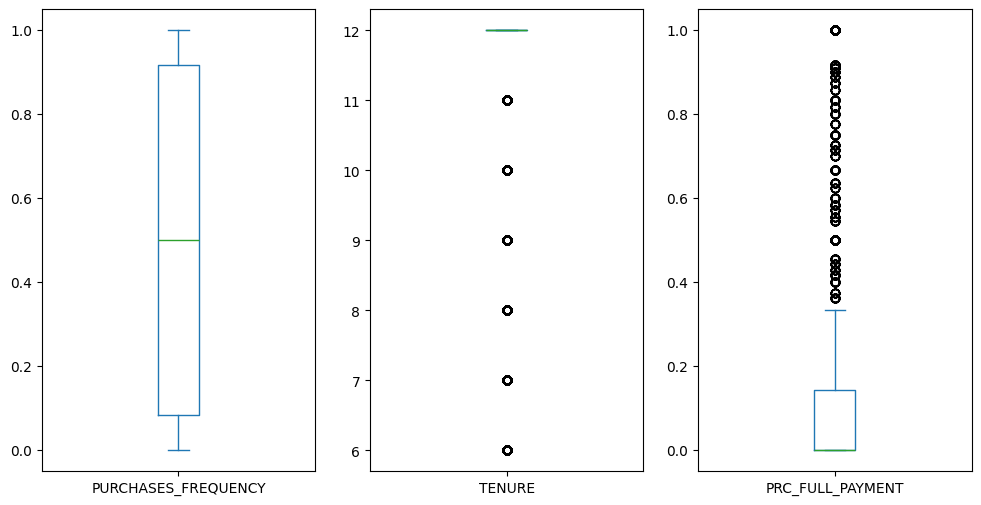

In [26]:
# @title
# Simply plot them in a box plot to see how data is organized..

df[['PURCHASES_FREQUENCY', 'TENURE', 'PRC_FULL_PAYMENT']].plot(kind='box', subplots=True, layout=(1,3), figsize=(12,6))

# Observations from the output :
# PURCHASES_FREQUENCY -
# This variable appears to be well-scaled between 0 and 1,
# suggesting it might be a proportion or a frequency ratio.
# The box plot is showing a median value around 0.5, and it is nicely centered with outliers absent.

# TENURE -
# This variable seems to have discrete values with several outliers.
# This is unusual for a tenure variable, as we might expect tenure to be a continuous variable,
# possibly representing the number of months or years. However,
# if TENURE represents something like the number of years in tens (e.g., 10, 20, 30, etc.),
# then this distribution could make sense.
# But it seems more likely that the scale or the nature of the variable is different from the other two.

# PRC_FULL_PAYMENT -
# This box plot suggests that many of the values are clustered near 0,
# with a few outliers spread towards 1.
# This distribution might indicate that
# full payments are infrequent among the observations, with most people making partial payments.

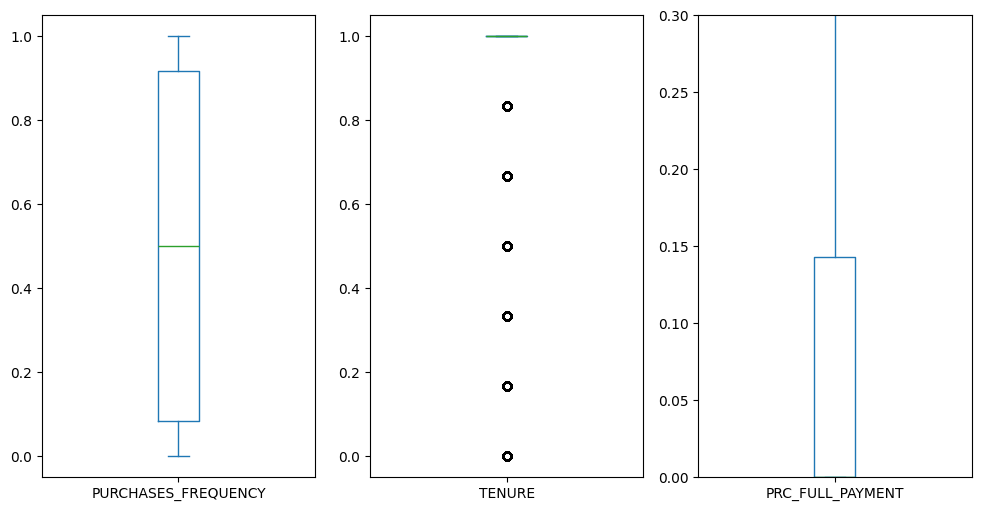

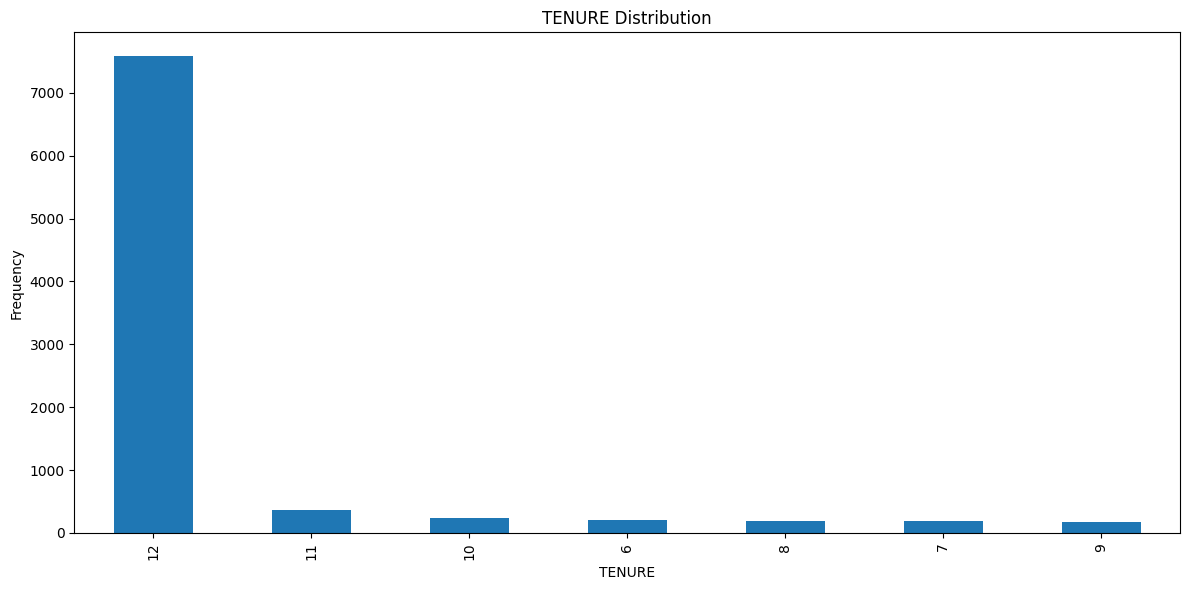

In [27]:
# @title
# Scaling - Normalizing the data to be between 0 and 1
df_scaled = (df[['PURCHASES_FREQUENCY', 'TENURE', 'PRC_FULL_PAYMENT']] - df[['PURCHASES_FREQUENCY', 'TENURE', 'PRC_FULL_PAYMENT']].min()) / (df[['PURCHASES_FREQUENCY', 'TENURE', 'PRC_FULL_PAYMENT']].max() - df[['PURCHASES_FREQUENCY', 'TENURE', 'PRC_FULL_PAYMENT']].min())

# Plotting scaled data
df_scaled.plot(kind='box', subplots=True, layout=(1,3), figsize=(12, 6))

# Adjusting ylim if necessary (example for 'PRC_FULL_PAYMENT')
plt.subplot(1, 3, 3) # Adjust the index accordingly
plt.ylim(0, 0.3) # Set the limit to focus on the main cluster of data

# If TENURE is a discrete variable, you might want to plot it differently:
plt.figure(figsize=(12, 6))
df['TENURE'].value_counts().plot(kind='bar')
plt.title('TENURE Distribution')
plt.xlabel('TENURE')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [29]:
df.isna().sum()

CUST_ID                             0
BALANCE                             0
BALANCE_FREQUENCY                   0
PURCHASES                           0
ONEOFF_PURCHASES                    0
INSTALLMENTS_PURCHASES              0
CASH_ADVANCE                        0
PURCHASES_FREQUENCY                 0
ONEOFF_PURCHASES_FREQUENCY          0
PURCHASES_INSTALLMENTS_FREQUENCY    0
CASH_ADVANCE_FREQUENCY              0
CASH_ADVANCE_TRX                    0
PURCHASES_TRX                       0
CREDIT_LIMIT                        0
PAYMENTS                            0
MINIMUM_PAYMENTS                    0
PRC_FULL_PAYMENT                    0
TENURE                              0
dtype: int64

In [28]:
df["MINIMUM_PAYMENTS"].fillna(df["MINIMUM_PAYMENTS"].mean(),inplace=True)
df["CREDIT_LIMIT"].fillna(df["CREDIT_LIMIT"].mean(),inplace=True)

In [30]:
df.isna().sum()

CUST_ID                             0
BALANCE                             0
BALANCE_FREQUENCY                   0
PURCHASES                           0
ONEOFF_PURCHASES                    0
INSTALLMENTS_PURCHASES              0
CASH_ADVANCE                        0
PURCHASES_FREQUENCY                 0
ONEOFF_PURCHASES_FREQUENCY          0
PURCHASES_INSTALLMENTS_FREQUENCY    0
CASH_ADVANCE_FREQUENCY              0
CASH_ADVANCE_TRX                    0
PURCHASES_TRX                       0
CREDIT_LIMIT                        0
PAYMENTS                            0
MINIMUM_PAYMENTS                    0
PRC_FULL_PAYMENT                    0
TENURE                              0
dtype: int64

In [31]:
df.duplicated().any()

False

ValueError: could not convert string to float: 'C10001'

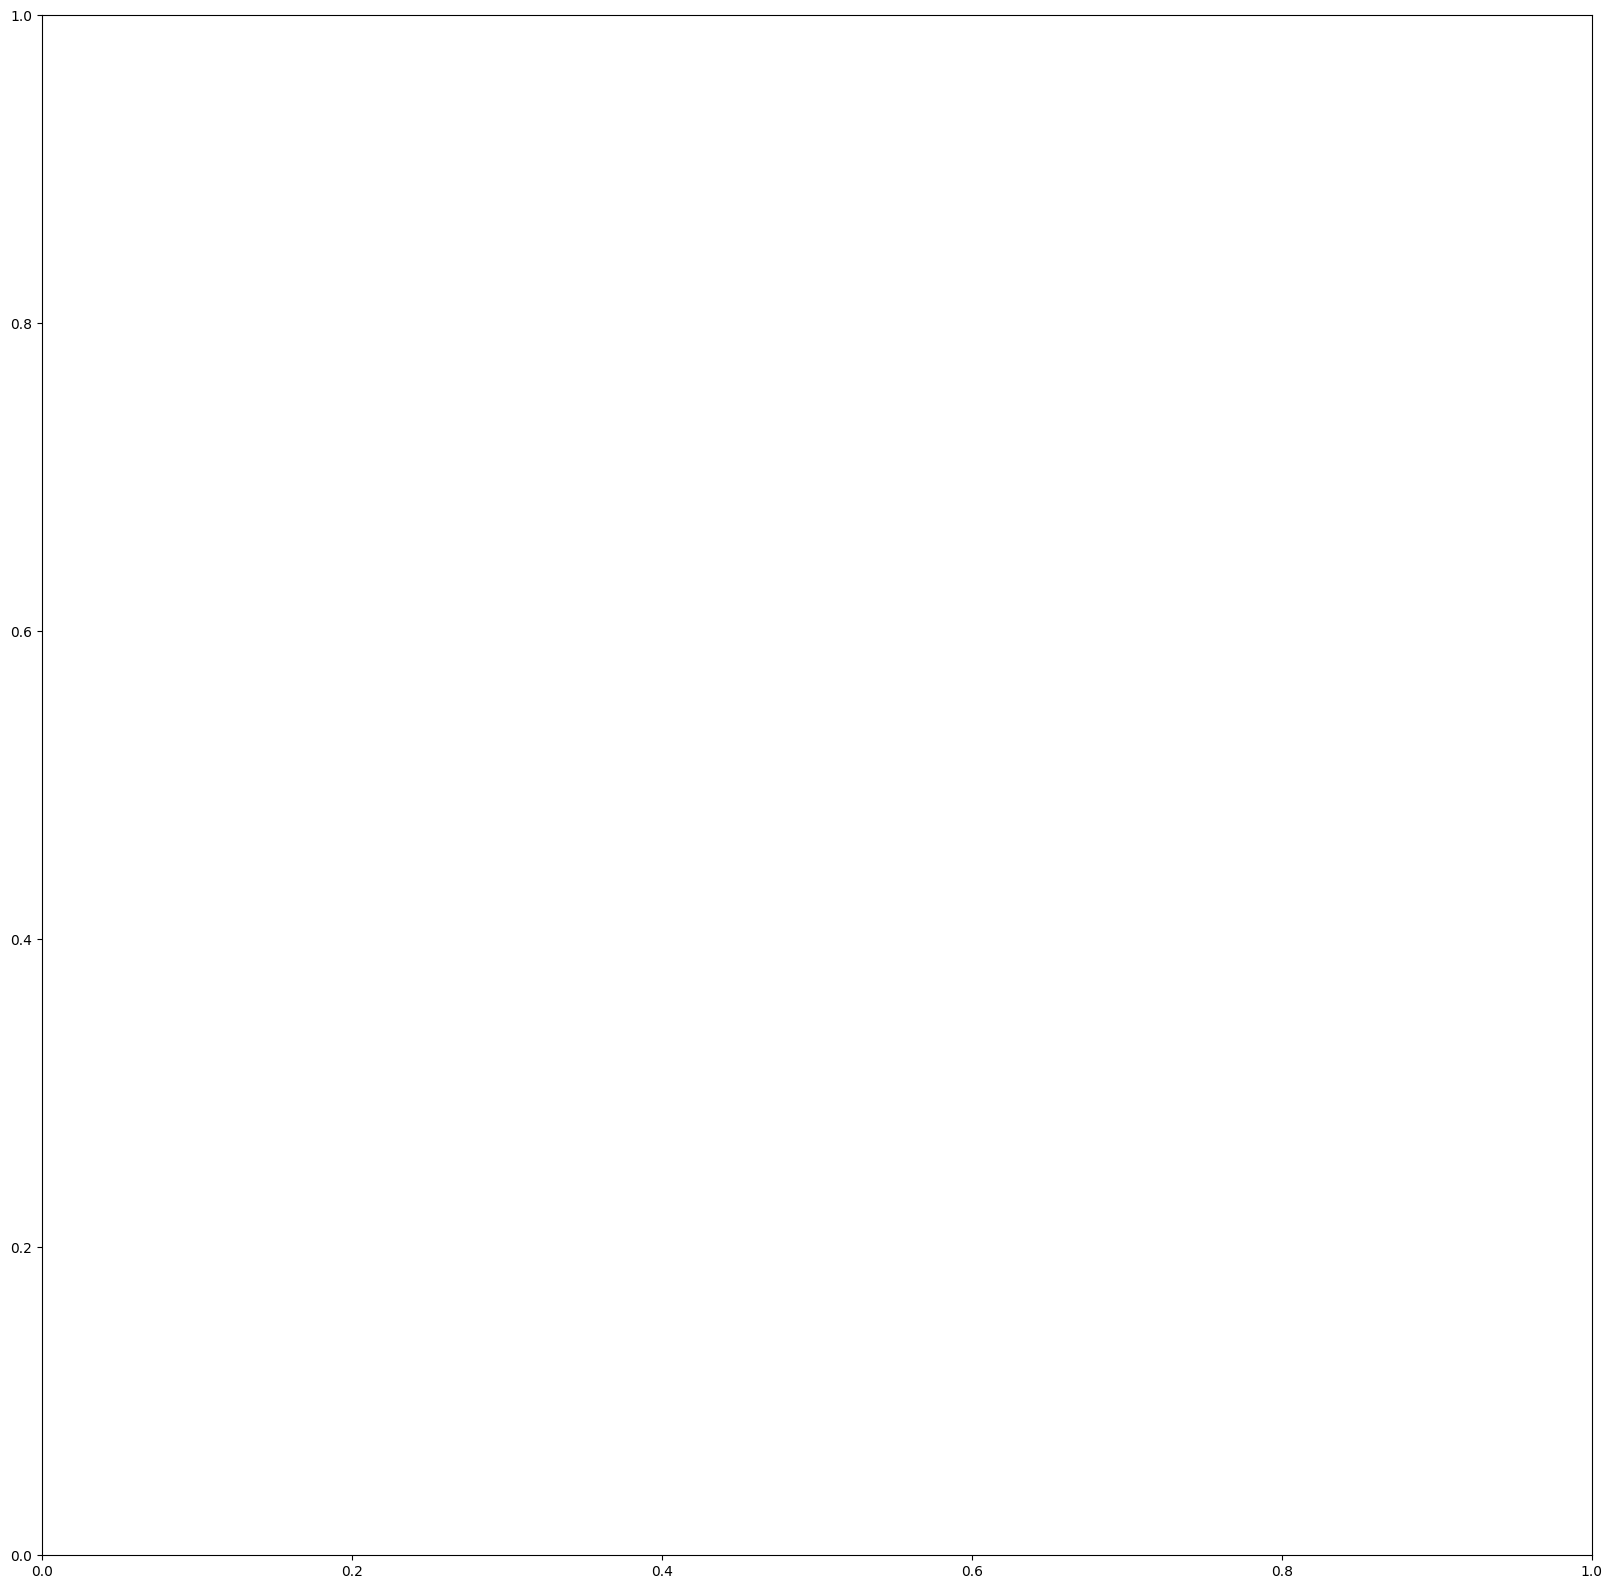

In [32]:
f, ax = plt.subplots(figsize = (20, 20))
sns.heatmap(df.corr(), annot=True)

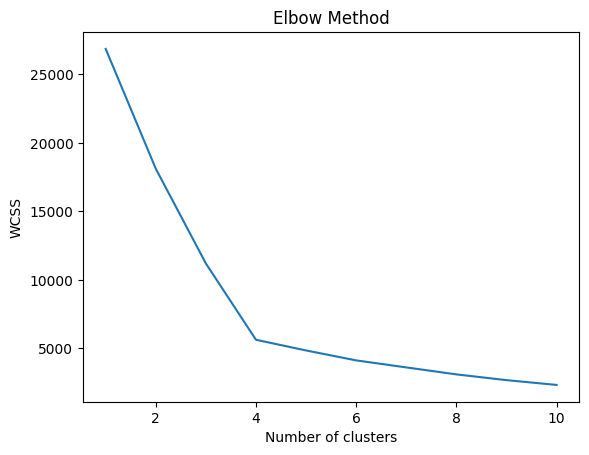

In [33]:
# Find the best number of clusters using elbow method for selected labes

df_features = df[['PURCHASES_FREQUENCY', 'PRC_FULL_PAYMENT', 'TENURE']]

# Step 2: Pre-process the data (example: standardization)
scaler = StandardScaler()
df_features_scaled = scaler.fit_transform(df_features)

# Step 3: Apply the Elbow Method
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(df_features_scaled)
    wcss.append(kmeans.inertia_)

# Step 4: Plotting to find the elbow point
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [34]:
X = df[['PURCHASES_FREQUENCY', 'PRC_FULL_PAYMENT', 'TENURE']]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Applying K-means clustering
kmeans = KMeans(n_clusters=3, random_state=0).fit(X)

# Assigning the cluster labels to your DataFrame as Loyalty_Category
df['Loyalty_Category'] = kmeans.labels_

# Optionally, you might want to map numeric clusters to categorical labels
loyalty_mapping = {0: '0-Bronze', 1: '1-Silver', 2: '2-Gold'}
df['Loyalty_Category'] = df['Loyalty_Category'].map(loyalty_mapping)
df.head()

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE,Loyalty_Category
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12,2-Gold
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12,2-Gold
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12,0-Bronze
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,864.206542,0.000000,12,2-Gold
4,C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12,2-Gold


In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
df.groupby('Loyalty_Category').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [35]:
df1 = df.copy()
loyalty_mapping2 = {'0-Bronze': 0,'1-Silver': 1,'2-Gold': 2,'3-Platinum': 3}

# Replace the string values with the corresponding numeric values
df1['Loyalty_Category'] = df1['Loyalty_Category'].replace(loyalty_mapping2)
pca = PCA(n_components=2)
principal_comp = pca.fit_transform(df1)
# principal_comp
pca_df = pd.DataFrame(data = principal_comp, columns =['pca1','pca2'])
pca_df = pd.concat([pca_df,pd.DataFrame({'cluster':df1['Loyalty_Category']})], axis = 1)
plt.figure(figsize=(10,10))
ax = sns.scatterplot(x="pca1", y="pca2", hue = "cluster", data = pca_df, palette =['red','green','pink','purple'])
plt.show()

ValueError: could not convert string to float: 'C10001'

In [36]:

df = pd.read_csv('sample_data/marketing_data.csv')
df.dropna()
df.drop_duplicates(inplace=True)

# Selecting only the relevant features for clustering
df_selected_features = df[['PURCHASES_FREQUENCY', 'PRC_FULL_PAYMENT', 'TENURE']]

# Impute missing values using the median for the selected features
imputer = SimpleImputer(strategy='median')
df_selected_imputed = imputer.fit_transform(df_selected_features)

# Standardize the selected features
scaler = StandardScaler()
df_selected_scaled = scaler.fit_transform(df_selected_imputed)

# Apply DBSCAN clustering with determined parameters
# These parameters should be adjusted based on the specific dataset characteristics
dbscan = DBSCAN(eps=2.5, min_samples=34)
clusters_selected_features = dbscan.fit_predict(df_selected_scaled)

# Count the number of clusters and noise points
n_clusters_selected_features = len(set(clusters_selected_features)) - (1 if -1 in clusters_selected_features else 0)
n_noise_selected_features = list(clusters_selected_features).count(-1)

# Prepare the results in a new DataFrame for better visualization
result_df_selected_features = pd.DataFrame({
    'CUST_ID': df['CUST_ID'],
    'CLUSTER': clusters_selected_features
})

print("Number of clusters:", n_clusters_selected_features)
print("Number of noise points:", n_noise_selected_features)
print(result_df_selected_features.head())

Number of clusters: 1
Number of noise points: 0
  CUST_ID  CLUSTER
0  C10001        0
1  C10002        0
2  C10003        0
3  C10004        0
4  C10005        0


In [37]:
# df = pd.read_csv('sample_data/marketing_data.csv')

# Selecting only the relevant features for clustering
df_selected_features = df[['PURCHASES_FREQUENCY', 'PRC_FULL_PAYMENT', 'TENURE']]

# Impute missing values using the median for the selected features
imputer = SimpleImputer(strategy='median')
df_selected_imputed = imputer.fit_transform(df_selected_features)

# Standardize the selected features
scaler = StandardScaler()
df_selected_scaled = scaler.fit_transform(df_selected_imputed)

# Apply KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(df_selected_scaled)

# Calculate the silhouette coefficient
silhouette_avg = silhouette_score(df_selected_scaled, clusters)

# Print the silhouette score
print("The average silhouette_score is :", silhouette_avg)

# Function to compute purity score
def purity_score(y_true, y_pred):
    # compute contingency matrix (also called confusion matrix)
    contingency_matrix = metrics.cluster.contingency_matrix(y_true, y_pred)
    # return purity
    return np.sum(np.amax(contingency_matrix, axis=0)) / np.sum(contingency_matrix)

# Assuming you have true labels in 'class_label_column'
# purity = purity_score(df['class_label_column'], clusters)
# print("The purity score is :", purity)

# Print the cluster assignments
print(clusters[:10])  # showing only the first 10 cluster assignments

# So, a silhouette score of approximately 0.585 suggests that on average,
# objects are relatively well clustered.
# In other words, each data point is, on average,
# closer to the points in its own cluster than to points in other clusters,
# though there might still be some overlap or closely positioned clusters.
# This is generally a sign that the clustering configuration is fairly good and
# that the clusters are distinct from each other.

The average silhouette_score is : 0.5327734805705894
[0 0 0 0 0 0 2 0 0 0]
